In [1]:
import datetime

import shutil
import requests

import time
import os
from netCDF4 import Dataset

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from netCDFfunc.utility import to_img, cropping

In [2]:
most_recent = datetime.datetime.now()-datetime.timedelta(days=175)

In [3]:
most_recent

datetime.datetime(2022, 2, 28, 12, 42, 58, 900403)

In [4]:
j_day = most_recent.strftime('%j')
j_day = int(j_day)

In [5]:
def to_img(arr, output_path='', date=(), lon=None, lat=None, figsize=(), save_img=False, show_img=False, is_anomaly = False, is_grade=False):
    
    plt.style.use('default')
    
    if date != () : 
        month, day = date   
        date = dt.date(-1,month,day).strftime('%m%d')
    else :
        date = ''
    
    if figsize == ():
        x, y = arr.shape
    else :
        x,y = figsize
        
    x = x/60
    y = y/60
    
    fig, ax = plt.subplots(figsize=(24,12))
    gca_ax = plt.gca()
    
    if arr.dtype == np.float32:
        np.place(arr, arr[:,:]==-999, np.nan)
    
    cmap = cm.jet.copy()

    if is_anomaly == True :
        cmap = cm.RdBu_r.copy()
        vmax = 8.5
        vmin = -7.3
        
    elif is_grade == True :
        vmax = 5
        vmin = 0
        
        grade_0 = np.array([179/256, 241/256, 255/256, 1])
        grade_1 = np.array([255/256, 255/256, 128/256, 1])
        grade_2 = np.array([255/256, 179/256, 53/256, 1])
        grade_3 = np.array([255/256, 129/256, 0/256, 1])
        grade_4 = np.array([203/256, 76/256, 1/256, 1])
        grade_5 = np.array([153/256, 26/256, 0/256, 1])
        new_cmap = np.array([grade_0, grade_1, grade_2, grade_3, grade_4, grade_5])

        if 5 not in arr :
            new_cmap = new_cmap[:-1]
            if 4 not in arr :
                new_cmap = new_cmap[:-1]
                if 3 not in arr :
                    new_cmap = new_cmap[:-1]
                    if 2 not in arr :
                        new_cmap = new_cmap[:-1]
                        if 1 not in arr :
                            new_cmap = new_cmap[:-1]
            
        cmap = ListedColormap(new_cmap)
        
    cmap.set_bad(color='gray')
    cmap.set_under(color=np.array([250/256, 250/256, 250/256, 1]))
    
    if type(lat) != np.ndarray or type(lon) != np.ndarray :
        if is_anomaly == True : im = plt.imshow(arr, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
        elif is_grade == True : im = plt.imshow(arr, cmap=cmap, origin='lower', vmin=vmin)
        else : im = plt.imshow(arr, cmap=cmap, origin='lower')
    else :
        im = plt.imshow(arr, cmap=cmap, origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], vmin=vmin, vmax=vmax) 
    
        plt.xticks(range(0,361, 20))
        plt.yticks(range(-80,81,20))
        plt.grid(True, linestyle='--', color='black')
        
        x_labels = ['20°E','40°E','60°E','80°E','100°E','120°E','140°E','160°E','180°','160°W','140°W','120°W','100°W','80°W','60°W','40°W','20°W','0','20°E']
        y_labels = ['80°S','60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N']
        ax.set_xticklabels(x_labels)
        ax.set_yticklabels(y_labels)
    
    divider = make_axes_locatable(gca_ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    if is_grade != True : 
        plt.colorbar(im, cax=cax)
    
    plt.text(-30,0.9,f'{date}',{'fontsize':30}, transform=plt.gca().transAxes, va='top', ha='left')
    
    if save_img == True :
        plt.savefig(output_path, dpi=150, bbox_inches='tight')

    if show_img == True :
        plt.show()
    plt.close()


In [380]:
def download_data(output_path, sepcific_date=None, start_date=None, end_date=None, dataset_names=None):
    ''' 
    start_date and end_date = Tuple (Year, Month, Day)
    
     1) start_date and end_date == None : most_recent
     2) start_date != None and end_date == None : start_date ~ most_recent
     3) start_date != None and end_date != None : start_date ~ end_date

    dataset_names = list of (AVHRR, CMC, DMI, GAMSSA, MUR25, MUR0.01, MWIR, MW, NAVO, OSPON, OSPO, OSTIA)
    '''
    most_recent = datetime.datetime.now()-datetime.timedelta(days=175)

    if start_date == None and end_date == None :    
        year = most_recent.strftime('%Y')
        date = most_recent.strftime('%Y%m%d')
        
        j_day = most_recent.strftime('%j')
        j_day = '%03d' % int(j_day)
        
    
    if dataset_names == None :
        dataset_names = ['AVHRR', 'CMC', 'DMI', 'GAMSSA', 'MUR25', 'MUR', 'MWIR', 'MW', 'NAVO', 'OSPON', 'OSPO', 'OSTIA']
    
    
    common_url = 'https://podaac-opendap.jpl.nasa.gov/opendap/hyrax/allData/ghrsst/data'

    for dataset_name in dataset_names :
        
        if dataset_name == 'AVHRR':
            file_name = f'{date}120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc'
            url = f'{common_url}/GDS2/L4/GLOB/NCEI/AVHRR_OI/v2.1/{year}/{j_day}/{file_name}'
        
        elif dataset_name == 'CMC' :
            file_name = f'{date}120000-CMC-L4_GHRSST-SSTfnd-CMC0.1deg-GLOB-v02.0-fv03.0.nc'
            url = f'{common_url}/GDS2/L4/GLOB/CMC/CMC0.1deg/v3/{year}/{j_day}/{file_name}'
            
        elif dataset_name == 'DMI' :
            file_name = f'{date}000000-DMI-L4_GHRSST-SSTfnd-DMI_OI-GLOB-v02.0-fv01.0.nc'
            url = f'{common_url}/GDS2/L4/GLOB/DMI/DMI_OI/v1/{year}/{j_day}/{file_name}'
            
        elif dataset_name == 'GAMSSA' :
            file_name = f'{date}120000-ABOM-L4_GHRSST-SSTfnd-GAMSSA_28km-GLOB-v02.0-fv01.0.nc'
            url = f'{common_url}/GDS2/L4/GLOB/ABOM/GAMSSA/v1.0/{year}/{j_day}/{file_name}'
            
        elif dataset_name == 'MUR25' :
            file_name = f'{date}090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc'
            url = f'{common_url}/GDS2/L4/GLOB/JPL/MUR25/v4.2/{year}/{j_day}/{file_name}'
            
        elif dataset_name == 'MUR' :
            file_name = f'{date}090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'
            url = f'{common_url}/GDS2/L4/GLOB/JPL/MUR/v4.1/{year}/{j_day}/{file_name}'
            
        elif dataset_name == 'MWIR' :
            file_name = f'{date}120000-REMSS-L4_GHRSST-SSTfnd-MW_IR_OI-GLOB-v02.0-fv05.0.nc'
            url = f'{common_url}/GDS2/L4/GLOB/REMSS/mw_ir_OI/v5.0/{year}/{j_day}/{file_name}'
            
        elif dataset_name == 'MW' :
            file_name = f'{date}120000-REMSS-L4_GHRSST-SSTfnd-MW_OI-GLOB-v02.0-fv05.0.nc'
            url = f'{common_url}/GDS2/L4/GLOB/REMSS/mw_OI/v5.0/{year}/{j_day}/{file_name}'
            
        elif dataset_name == 'NAVO' :
            file_name = f'{date}000000-NAVO-L4_GHRSST-SST1m-K10_SST-GLOB-v02.0-fv01.0.nc'
            url = f'{common_url}/GDS2/L4/GLOB/NAVO/K10_SST/v1/{year}/{j_day}/{file_name}'
            
        elif dataset_name == 'OSPON' :
            file_name = f'{date}000000-OSPO-L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0.nc'
            url = f'{common_url}/GDS2/L4/GLOB/OSPO/Geo_Polar_Blended_Night/v1/{year}/{j_day}/{file_name}'
            
        elif dataset_name == 'OSPO' :
            file_name = f'{date}000000-OSPO-L4_GHRSST-SSTfnd-Geo_Polar_Blended-GLOB-v02.0-fv01.0.nc'
            url = f'{common_url}/GDS2/L4/GLOB/OSPO/Geo_Polar_Blended/v1/{year}/{j_day}/{file_name}'
            
        elif dataset_name == 'OSTIA' :
            file_name = f'{date}-UKMO-L4HRfnd-GLOB-v01-fv02-OSTIA.nc.bz2'
            url = f'{common_url}/L4/GLOB/UKMO/OSTIA/{year}/{j_day}/{file_name}'
    
        response = requests.get(url, stream=True)
        
        if file_name.endswith('.bz2') : file_name = file_name.replace('.bz2', '')
        if not os.path.exists(os.path.join(output_path, dataset_name)) : os.mkdir(os.path.join(output_path, dataset_name))
            
        with open(os.path.join(output_path, dataset_name, file_name), 'wb') as out_file:
            print(f'{dataset_name} downloading...')
            shutil.copyfileobj(response.raw, out_file)
            
        del response

In [6]:
download_data('/Volumes/T7/download_data/')

AVHRR downloading...
CMC downloading...
DMI downloading...
GAMSSA downloading...
MUR25 downloading...
MUR downloading...
MWIR downloading...
MW downloading...
NAVO downloading...
OSPON downloading...
OSPO downloading...
OSTIA downloading...


In [6]:
def cropping(arr, region, grid_size):
    ratio = 0.25 / grid_size
    
    if region == 'rok':
        return arr[int(440 * ratio):int(572 * ratio), int(1160 * ratio):int(1320 * ratio)]
    if region == 'nw':
        return arr[280:624, 392:1136]
    if region == 'global':
        return arr

In [7]:
data_dir = f'/Volumes/T7/download_data/MWIR/'
data_file = os.listdir(data_dir)[0]
ds_in = Dataset(os.path.join(data_dir,data_file), 'r', format='NETCDF4')

In [8]:
dataset_names = ['AVHRR', 'CMC', 'DMI', 'GAMSSA', 'MUR25', 'MUR', 'MWIR', 'MW', 'NAVO', 'OSPON', 'OSPO', 'OSTIA']
data_dic = dict()
grid_dic = dict()
lat_dic = dict()
lon_dic = dict()

for dataset_name in dataset_names:
    
    data_dir = f'/Volumes/T7/download_data/{dataset_name}/'
    data_file = os.listdir(data_dir)[0]
    ds_in = Dataset(os.path.join(data_dir,data_file), 'r', format='NETCDF4')
    sst = ds_in.variables['analysed_sst'][:].data[0]
    try :
        grid = ds_in.geospatial_lat_resolution
    except :
        grid = 0.05
    lat = ds_in.variables['lat'][:].data
    lon = ds_in.variables['lon'][:].data
    
    data_dic[dataset_name] = sst
    grid_dic[dataset_name] = grid
    lat_dic[dataset_name] = lat
    lon_dic[dataset_name] = lon
    
    ds_in.close()

In [6]:
ds_mean = dict()
ds_mean['0.01'] = Dataset('/Volumes/T7/intermediate_output/resize_test/Resize_test_0220_0.01.nc', 'r', format='NETCDF4').variables['avgsst'][:].data[0]
ds_mean['0.05'] = Dataset('/Volumes/T7/intermediate_output/resize_test/Resize_test_0220_0.05.nc', 'r', format='NETCDF4').variables['avgsst'][:].data[0]
ds_mean['0.054'] = Dataset('/Volumes/T7/intermediate_output/resize_test/Resize_test_0220_0.054.nc', 'r', format='NETCDF4').variables['avgsst'][:].data[0]
ds_mean['0.081'] = Dataset('/Volumes/T7/intermediate_output/resize_test/Resize_test_0220_0.081.nc', 'r', format='NETCDF4').variables['avgsst'][:].data[0]
ds_mean['0.1'] = Dataset('/Volumes/T7/intermediate_output/resize_test/Resize_test_0220_0.1.nc', 'r', format='NETCDF4').variables['avgsst'][:].data[0]
ds_mean['0.25'] = Dataset('/Volumes/T7/new_data/processed_data/processed_data_1_rok_avg/30_years_dataset_1_rok_0220.nc', 'r', format='NETCDF4').variables['avgsst'][:].data[0]

In [12]:
name = 'DMI' #()
print(grid_dic[name])
print(lat_dic[name])
print(lon_dic[name])

0.05
[-89.      -88.95    -88.9     ...  88.90001  88.95     89.     ]
[-179.975   -179.925   -179.875   ...  179.875    179.92499  179.975  ]


In [238]:
np.min(ds_mean[str(grid_dic[ds])])

-999.0

In [245]:
0.875 / 0.05

17.5

In [382]:
ds = 'MW'

for ds in dataset_names :
    data = data_dic[ds].copy()
    if ds == 'MWIR':
        continue
    if ds == 'NAVO':
        data = np.flip(data, axis=0)
#         data = np.roll(data, -2, axis=1)
#         data = np.roll(data, -2, axis=0)
    if ds == 'DMI':
        data = np.roll(data, 18, axis=0)
    np.place(data, data[:,:] <= -32767., np.nan)

    grid_size = float(grid_dic[ds])
    anomaly = ds_mean[str(grid_dic[ds])] - cropping(data - 273.15, 'rok', grid_size=grid_size)
    np.place(anomaly, anomaly[:,:] < -100, np.nan)

    to_img(anomaly, f'/Volumes/T7/intermediate_output/regrid_anomaly/{ds}({grid_size:.2f}).png', save_img=True, show_img=False, is_anomaly=True)

In [356]:
print(
    f'''
{ds}
{grid_dic[ds]}
min : {np.nanmin(anomaly)}
max : {np.nanmax(anomaly)}
mean : {np.nanmean(anomaly)}
median : {np.nanmedian(anomaly)}
    '''
)


OSTIA
0.05
min : -6.643327236175537
max : 8.214680671691895
mean : -0.2002459019422531
median : -0.15065574645996094
    


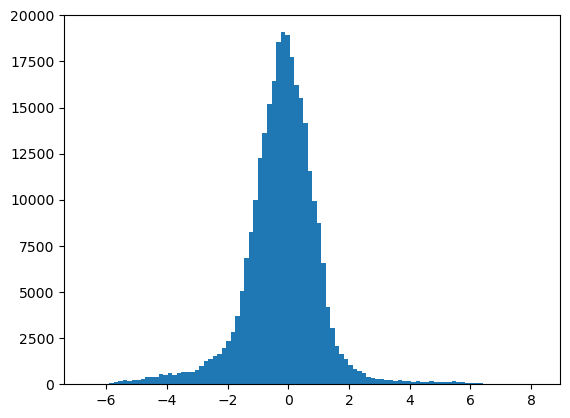

In [358]:
plt.hist(anomaly.flatten(), bins=100)
plt.show()